# Молекулярный докинг

In [3]:
import numpy as np
import copy

# Отображение структур
import IPython.display
import ipywidgets
from IPython.display import display,display_svg,SVG,Image

# Open Drug Discovery Toolkit
import oddt
import oddt.docking
import oddt.interactions

# Органика
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

В этом практикуме мы будем проводить молекулярный докинг белка - лизоцима, структура которого была предсказана нами в предыдущем практикуме, и низкомолекулярных лигандов. Для начала загрузим полученную ранее структуру и посмотрим, какие в ней есть атомы.

In [99]:
import mdtraj as md
u = md.load('CRAGI.B99990001.pdb')
pdb = u.topology
for i,r in enumerate(pdb.atoms):
    print(i,r)
    if i == 10:
        break
print('и т.д.')

0 MET1-N
1 MET1-CA
2 MET1-CB
3 MET1-CG
4 MET1-SD
5 MET1-CE
6 MET1-C
7 MET1-O
8 GLN2-N
9 GLN2-CA
10 GLN2-CB
и т.д.


Теперь мы можем вырезать лиганд и сохранить структуру белка без него.

In [4]:
# сохраним pdb без лиганда
u2 = u.atom_slice(range(1062))
u2.save_pdb('myprot-clean.pdb', force_overwrite=True)

Теперь определим геометрический центр лиганда в связанном состоянии, чтобы знать, куда дочить новые лиганды.

In [3]:
lig = u.atom_slice(range(1062,1105))
for v in lig.xyz:
    x=[]
    y=[]
    z=[]
    for i in v:
        x.append(i[0])
        y.append(i[1])
        z.append(i[2])
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        z_mean = np.mean(z)
print(x_mean,y_mean,z_mean)

4.3515186 3.9216535 2.6360788


Далее создадим молекулы новых лигандов и посмотрим на них.

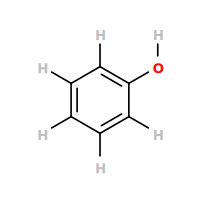

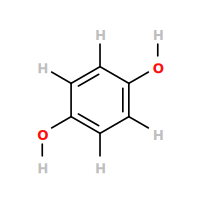

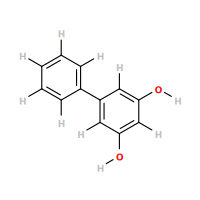

In [4]:
smiles = ['c1cccc(O)c1', 'c1c(O)ccc(O)c1','c1(O)cc(c2ccccc2)cc(O)c1']
mols= []
images =[]

for s in smiles:
    m = oddt.toolkit.readstring('smi', s)
    if not m.OBMol.Has3D(): 
        m.make3D(forcefield='mmff94', steps=150)
        ### Опять всё сделают за Вас
        ###m.removeh()
        ###m.OBMol.AddPolarHydrogens()

    mols.append(m)
    ###with print m.OBMol.Has3D() was found that:
    ### deep copy needed to keep 3D , write svg make mols flat
    images.append((SVG(copy.deepcopy(m).write('svg'))))
    
display_svg(*images)

Проводим докинг. Генерируем для каждого из трёх лигандов по 9 структур.

In [13]:
dock_obj= oddt.docking.AutodockVina.autodock_vina(
    protein='myprot-clean.pdb',size=(20,20,20),center=[43.515186,39.216535,26.360788],autocleanup=True, num_modes=9)

print(dock_obj.tmp_dir)
print(" ".join(dock_obj.params))

/tmp/autodock_vina_p6tbep3e
--center_x 43.515186 --center_y 39.216535 --center_z 26.360788 --size_x 20 --size_y 20 --size_z 20 --exhaustiveness 8 --num_modes 9 --energy_range 3


In [14]:
res = dock_obj.dock(mols,'myprot-clean.pdb')

Теперь сохраним результат в виде pdb-файла и посмотрим на него в PyMOL.

In [16]:
for i,r in enumerate(res):
    r.write(filename='r%s.pdb' % i, format='pdb',overwrite=True)

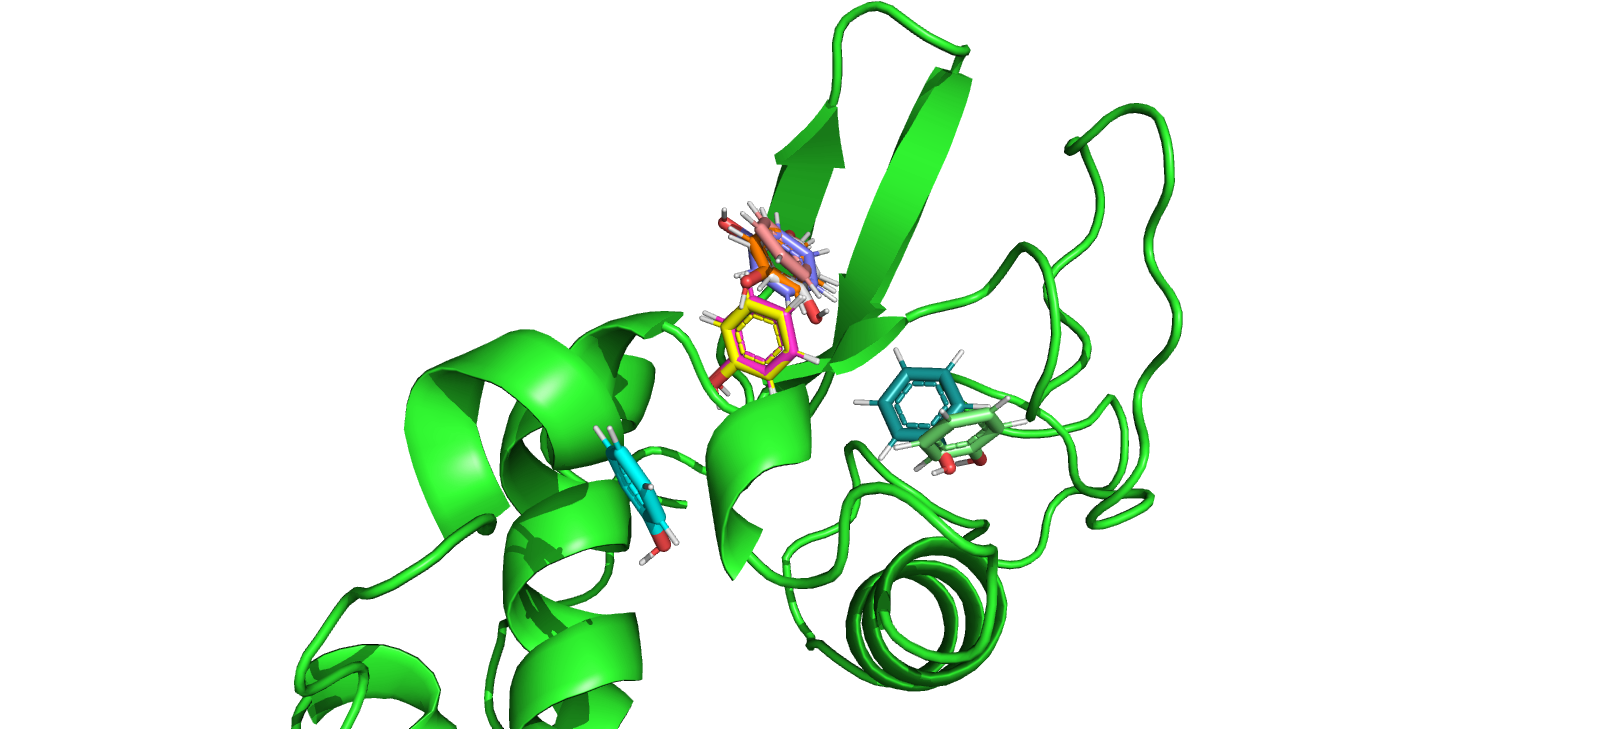

In [17]:
Image('dock_1.png', width=800)

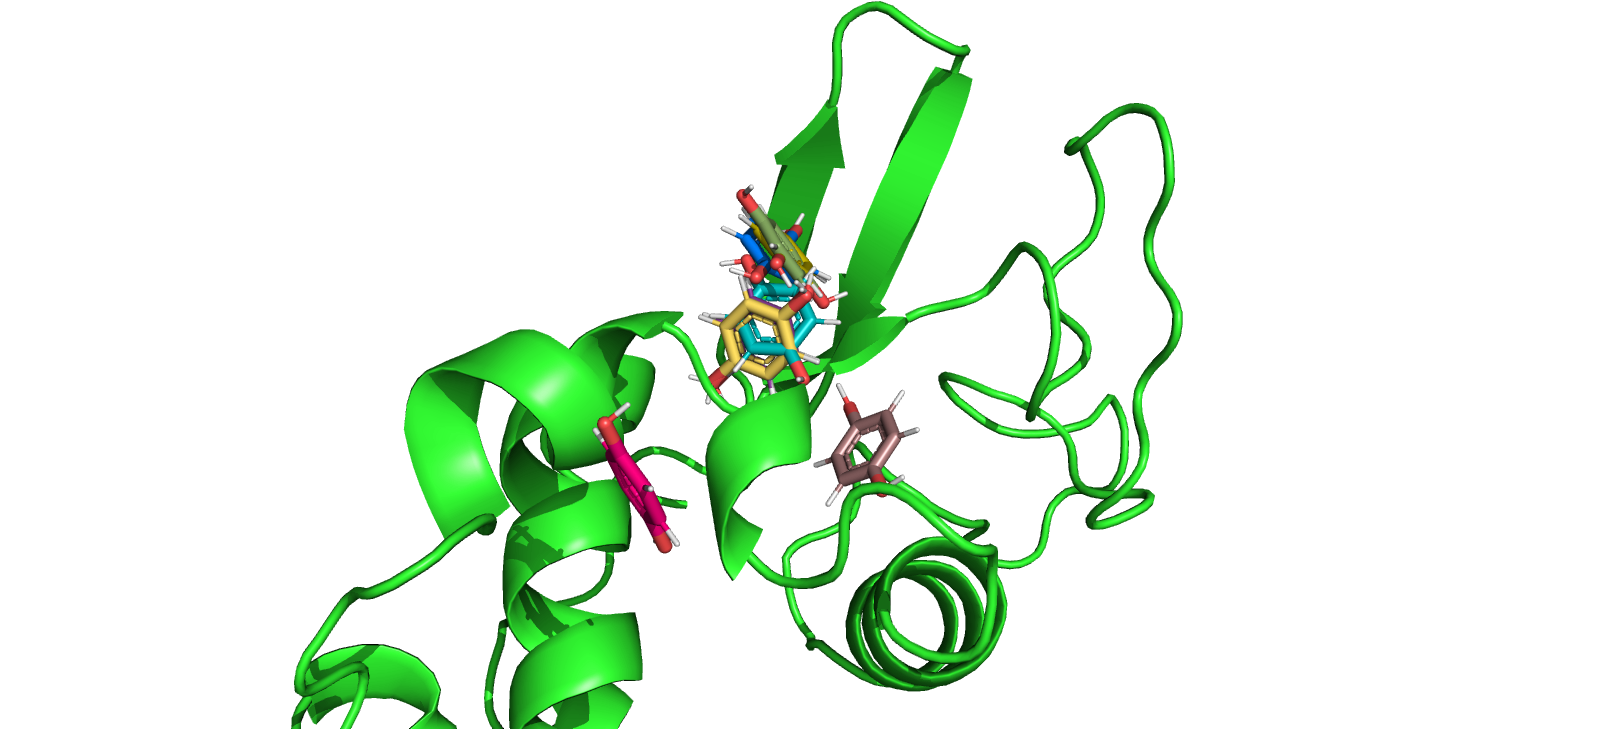

In [18]:
Image('dock_2.png', width=800)

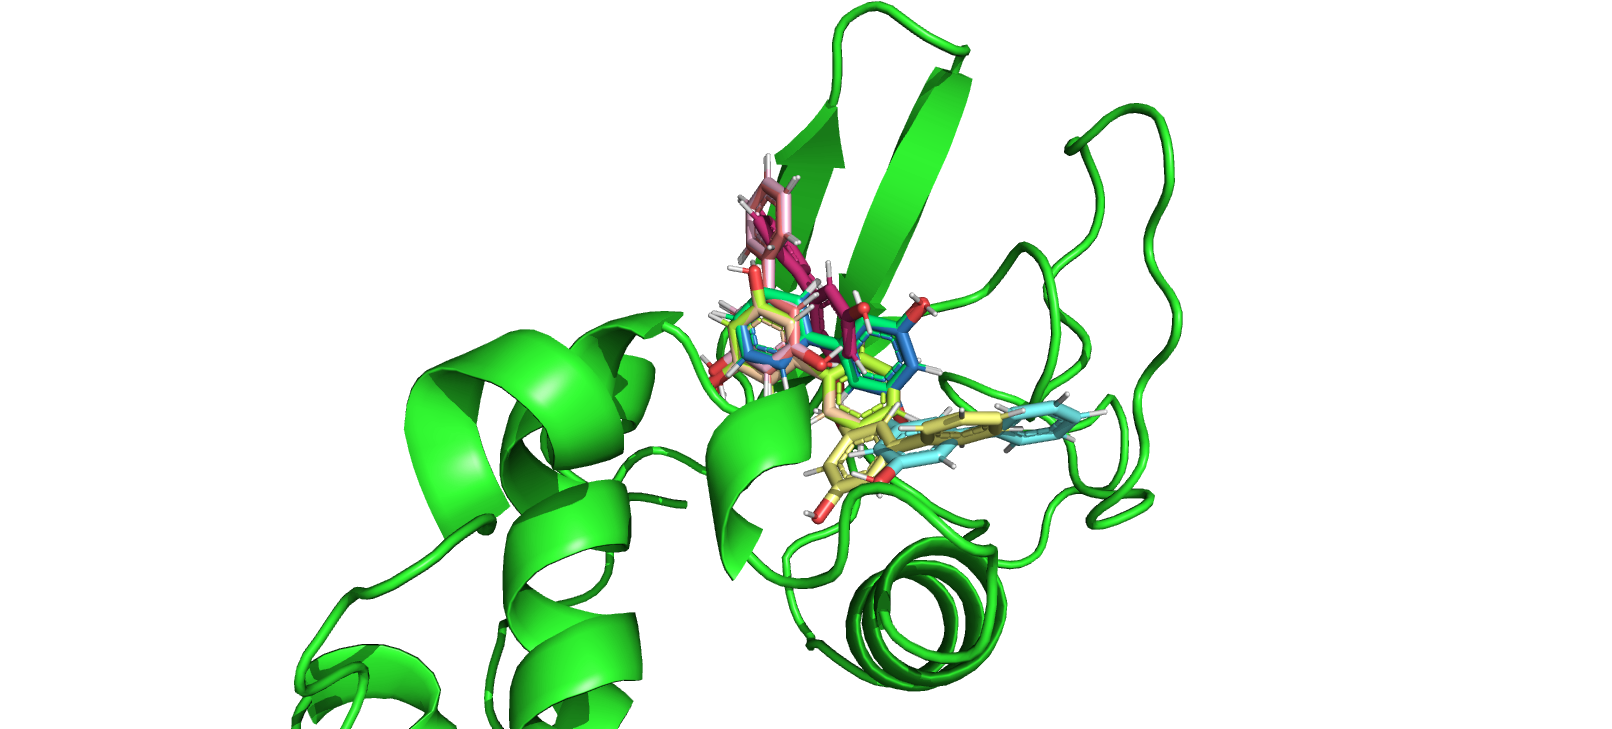

In [19]:
Image('dock_3.png', width=800)

В целом заметно, что в основном лиганды связываются в том же кармане, что и исходный, однако некоторые смогли связаться с белком и в других местах. Интересно, что даэе самый большой лиганд смог связаться несколькими различными способами, хотя можно было ожидать, что для него структура будет наиболее консервативна.

Теперь посмотрим, сколько взаимодействий каких типов присутсвуют в нашей выдаче.

In [20]:
prot = next(oddt.toolkit.readfile('pdb','myprot-clean.pdb'))

In [94]:
for i,r in enumerate(res):
    if i == 0:
        print('The first ligand')
    if i == 9:
        print('The second ligand')
    if i == 18:
        print('The third ligand')
    hbs = oddt.interactions.hbonds(prot,r)
    stack= oddt.interactions.pi_stacking(prot,r)
    phob = oddt.interactions.hydrophobic_contacts(prot,r)
    print('H-bonds:',len(hbs[2]),' pi_stacking:',len(stack[0]),' hydrophobic_contacts:',len(phob[0]))

The first ligand
H-bonds: 2  pi_stacking: 1  hydrophobic_contacts: 13
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 1
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 1
H-bonds: 2  pi_stacking: 0  hydrophobic_contacts: 4
H-bonds: 1  pi_stacking: 0  hydrophobic_contacts: 10
H-bonds: 1  pi_stacking: 0  hydrophobic_contacts: 10
H-bonds: 1  pi_stacking: 0  hydrophobic_contacts: 10
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 2
H-bonds: 1  pi_stacking: 0  hydrophobic_contacts: 2
The second ligand
H-bonds: 2  pi_stacking: 1  hydrophobic_contacts: 9
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 2
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 1
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 1
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 7
H-bonds: 2  pi_stacking: 0  hydrophobic_contacts: 4
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 5
H-bonds: 2  pi_stacking: 0  hydrophobic_contacts: 1
H-bonds: 3  pi_stacking: 0  hydrophobic_contacts: 3
The third ligand
H-bonds:

Выше для каждой из 27 сгенерированных структур приведено число найленных водородных связей, стекинг-взаимодействий и гидрофобных контактов. Стекинг-взаимодействия очень редки. По среднему числу водородных связей лидирует третий лиганд, гидрофобных контактов у него тоже больше всего (т.к. у него два кольца, то и места для гидрофобных взаимодействий больше).